#### Import libraries

In [1]:
# Import standard libraries
import os, datetime
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pl
import igraph
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import hvplot.pandas
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib')
%matplotlib inline

import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import seaborn as sb
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz
# import cairo
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import zscore
from scipy.sparse.linalg import norm
import networkx as nx
from pyvis.network import Network

## Load environment variables from .env file and find project root
import sys
from dotenv import load_dotenv, find_dotenv
load_dotenv()
PROJECT_ROOT = Path(find_dotenv()).parent
# data_path = Path(PROJECT_ROOT, 'results', 'eyemap')
store_path = Path(PROJECT_ROOT, 'results','AOTU_Connectivity')
sys.path.append(str(PROJECT_ROOT.joinpath('src')))


from utils import olc_client
c = olc_client.connect(verbose=True)

from utils.celltype_conn_by_roi import CelltypeConnByRoi
from utils.celltype_conn_plotter import CelltypeConnPlotter
from utils.plotter import plot_cns, save_figure, get_skeletons, get_skeleton, get_meshes, get_mesh, show_figure
from utils.helper import slugify
from utils.neuron_bag import NeuronBag

# Import neuPrint specific libraries
import neuprint
from neuprint import Client, fetch_neurons, NeuronCriteria as NC, fetch_neurons, fetch_simple_connections, fetch_adjacencies, connection_table_to_matrix, merge_neuron_properties, NotNull, fetch_synapse_connections, fetch_neurons,fetch_primary_rois, fetch_all_rois, fetch_synapses, fetch_roi_hierarchy
from neuprint.utils import connection_table_to_matrix


Loading BokehJS ...

Connected to https://neuprint-cns.janelia.org[male-cns:v0.9].
Client: neuprint-python v1.7.4
User: aishahamid201@gmail.com [readwrite]



# Fetch connections

In [2]:
n0, _ = fetch_neurons(NC(type='^LC.*'))
n1, _ = fetch_neurons(NC(type='^AOTU.*'))


/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/.pixi/envs/default/lib/python3.12/site-packages/neuprint/client.py:609: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]
/Users/hamida/Documents/GitHub/male-drosophila-visual-system-connectome-code/.pixi/envs/default/lib/python3.12/site-packages/neuprint/client.py:619: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]


In [3]:
instn0 = n0['instance'].unique()
instn1 = n1['instance'].unique() 

In [4]:
#  Set connection weight threshold
threshold = 5 #minimum 5 synapses

# Fetch synaptic connectivity between pre and post types
neu_df, conn_df = fetch_adjacencies(sources=NC(instance=instn0), targets=NC(instance=instn1), min_roi_weight=threshold)

# Merge with neuron properties to get types on both sides
conn_all_df = merge_neuron_properties(neu_df, conn_df)

# Group by type combinations and sum the weights by type
conn_inst = conn_all_df.groupby(['instance_pre','instance_post'])['weight'].sum().reset_index()


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# group by instance and sum the upstream values
wt_upstream = n1.groupby('instance').agg({'upstream': 'sum'}).reset_index()

In [6]:
# Art
# # match instance in wt_upstream to instance_post in conn_inst, then divide the weight in conn_inst by the upstream value
conn_inst = conn_inst.merge(wt_upstream, left_on='instance_post', right_on='instance', suffixes=('', '_upstream'))
conn_inst['wt_norm'] = conn_inst['weight'] / conn_inst['upstream']
conn_inst = conn_inst.drop(columns=['instance', 'upstream'])

In [7]:
conn_inst

,instance_pre,instance_post,weight,wt_norm
0,LC10_unclear_L,AOTU001_L,38,0.006642
1,LC10_unclear_L,AOTU002_a_L,104,0.028611
2,LC10_unclear_L,AOTU002_c_L,23,0.004952
3,LC10_unclear_L,AOTU013_L,13,0.005430
4,LC10_unclear_L,AOTU016_b_L,56,0.005412
...,...,...,...,...
511,LC4_R,AOTU034_R,6,0.002917
512,LC6_L,AOTU009_L,110,0.019870
513,LC6_R,AOTU009_R,188,0.029583
514,LC9_L,AOTU059_L,8,0.001789


# Create the connectivity matrix

## Raw_all

In [8]:
# Create matrix of connection weights: instance_pre to instance_post 
matrix_df = conn_inst.pivot_table(index='instance_pre', columns='instance_post', values='weight', aggfunc='sum', fill_value=0)

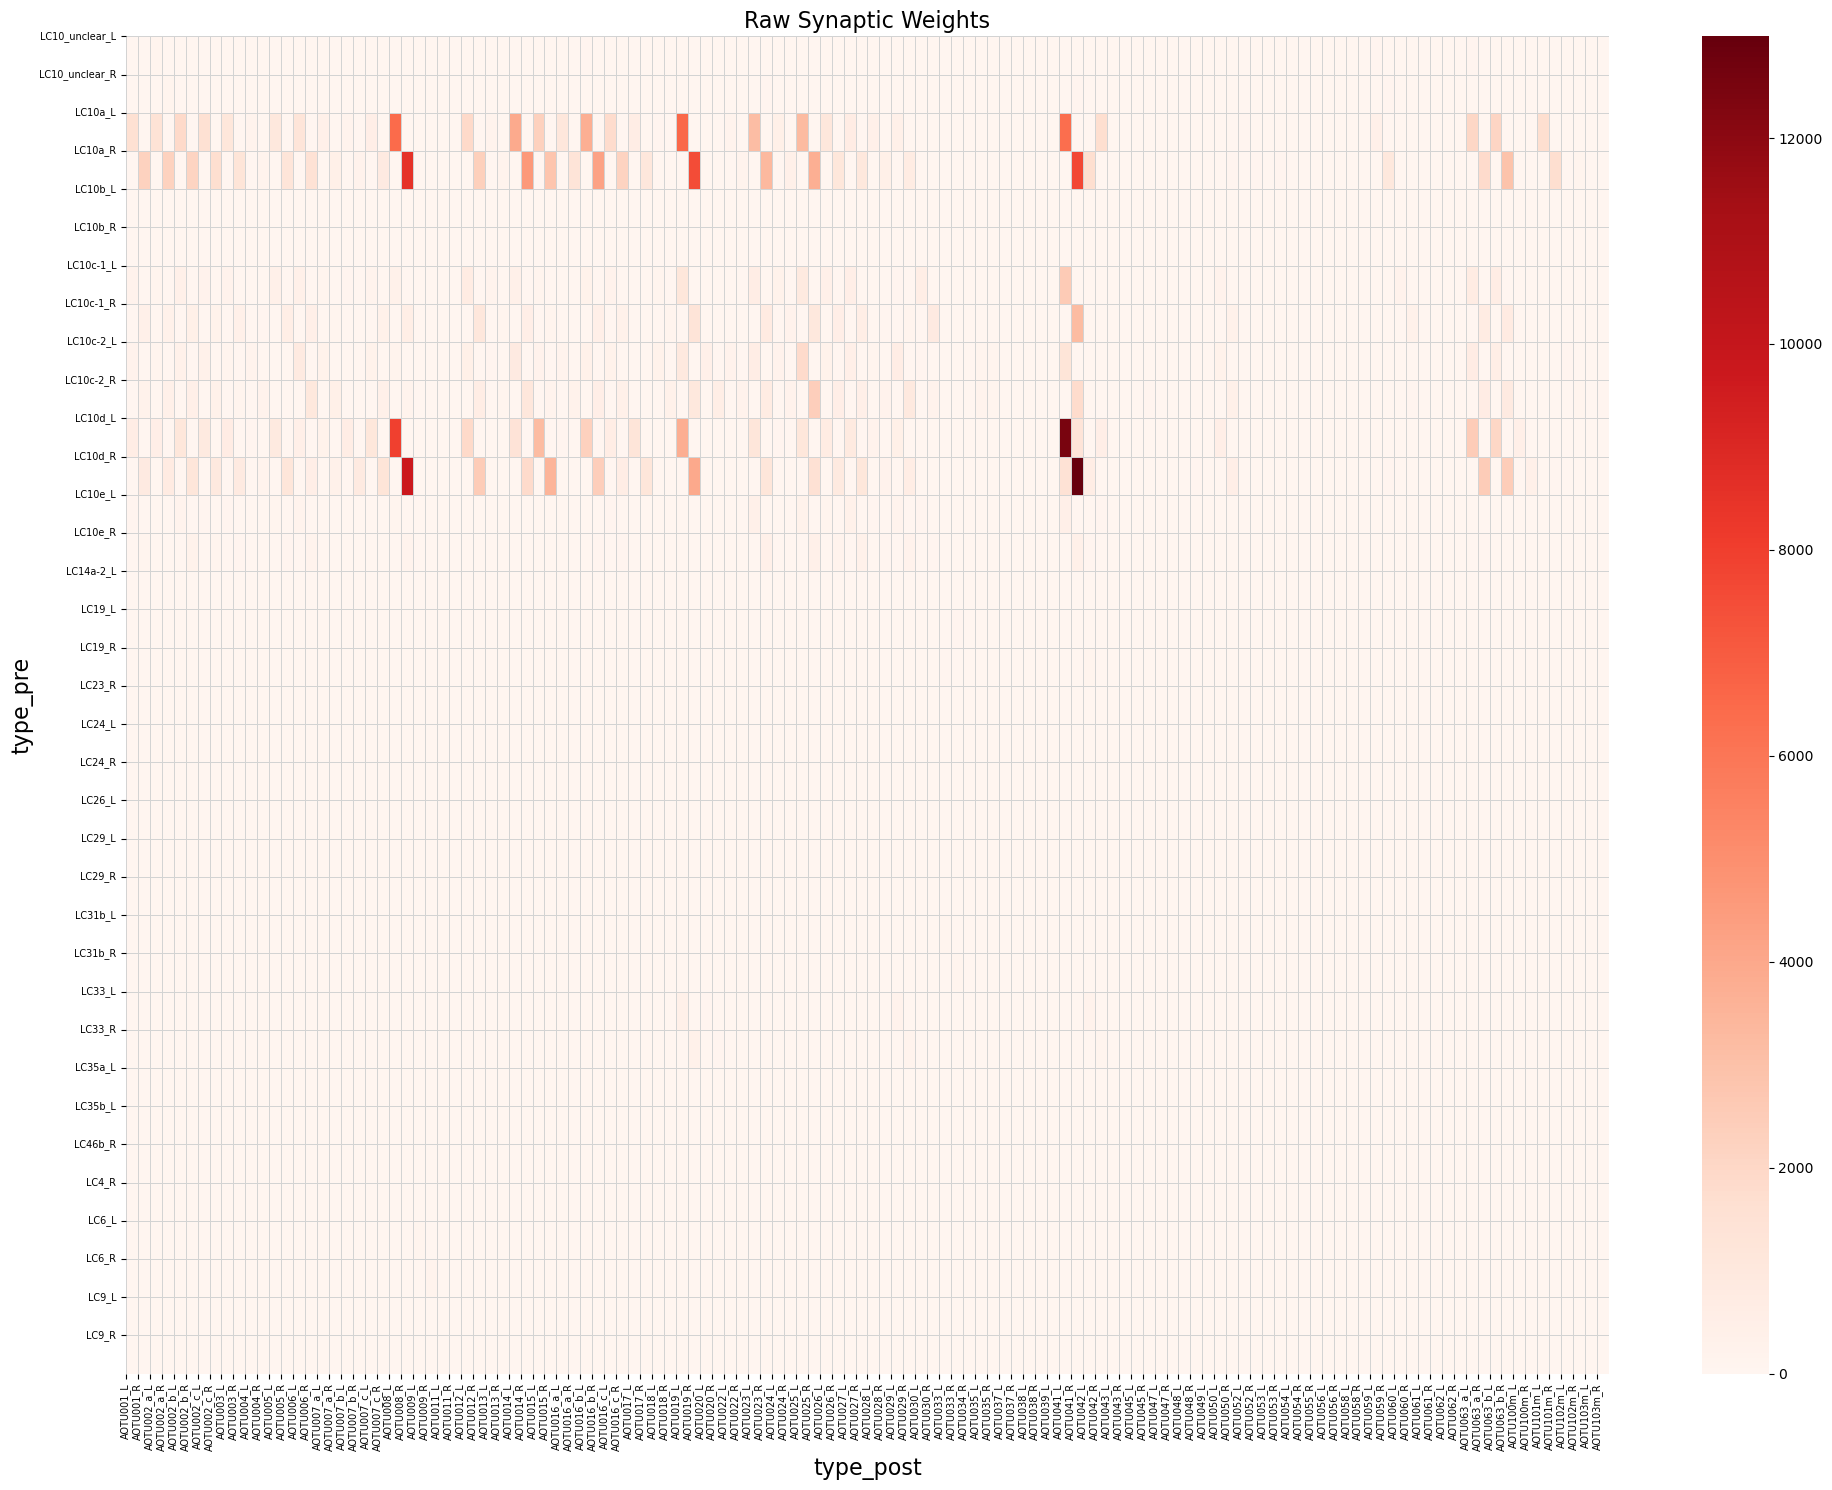

In [9]:
plt.figure(figsize=(20, 15))
ax = sb.heatmap(matrix_df, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray')

ax.set_title('Raw Synaptic Weights', fontsize = 16)
ax.set_xlabel('type_post', fontsize = 16)
ax.set_ylabel('type_pre', fontsize = 16)

ax.set_yticks(range(len(matrix_df.index)))
ax.set_yticklabels(matrix_df.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(matrix_df.columns)))
ax.set_xticklabels(matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
os.makedirs('results/AOTU', exist_ok=True)
plt.savefig('results/AOTU/Raw synaptic weights_LC_AOTU_all.png', dpi=600)

plt.show()

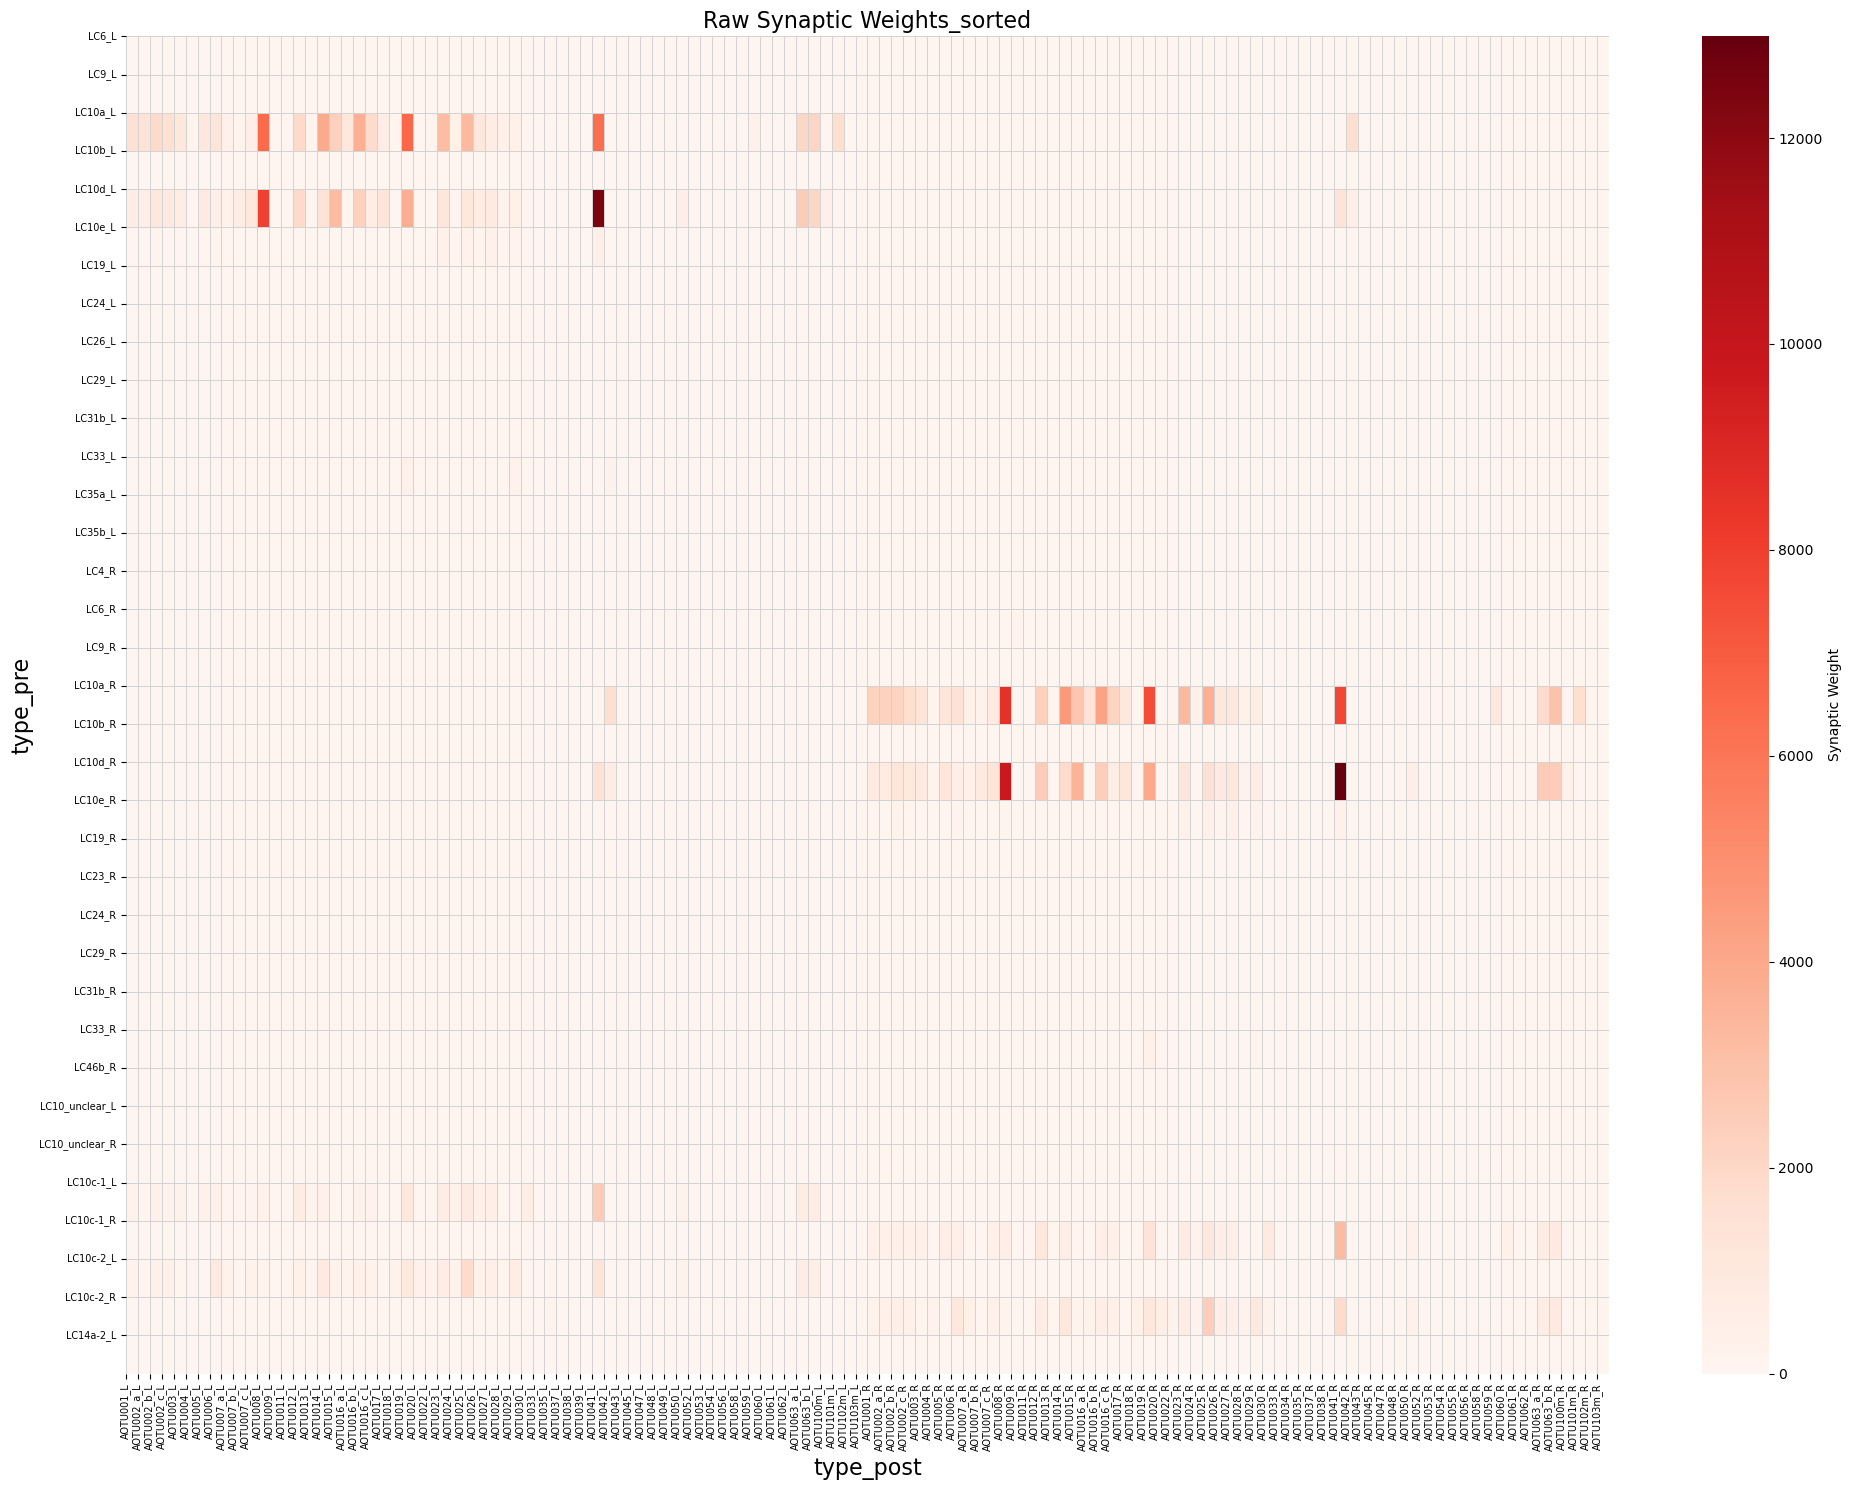

In [10]:
## Sorted heat map

import re
# Inline sorting using lambda
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and(m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)  # fallback if no match

# Get sorted row and column order
sorted_rows = sorted(matrix_df.index, key=sort_key)
sorted_cols = sorted(matrix_df.columns, key=sort_key)

# Reorder the matrix
ordered_matrix = matrix_df.loc[sorted_rows, sorted_cols]

plt.figure(figsize=(20, 15))
ax = sb.heatmap(ordered_matrix, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray', cbar_kws={"label": "Synaptic Weight"})

ax.set_title('Raw Synaptic Weights_sorted', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_matrix.index)))
ax.set_yticklabels(ordered_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(ordered_matrix.columns)))
ax.set_xticklabels(ordered_matrix.columns, rotation=90, fontsize=7)

#ax.invert_yaxis()
plt.tight_layout()

plt.savefig('results/AOTU/Raw synaptic weights_LC_AOTU_all_sorted.png', dpi=600)
plt.show()


### Top n inputs raw

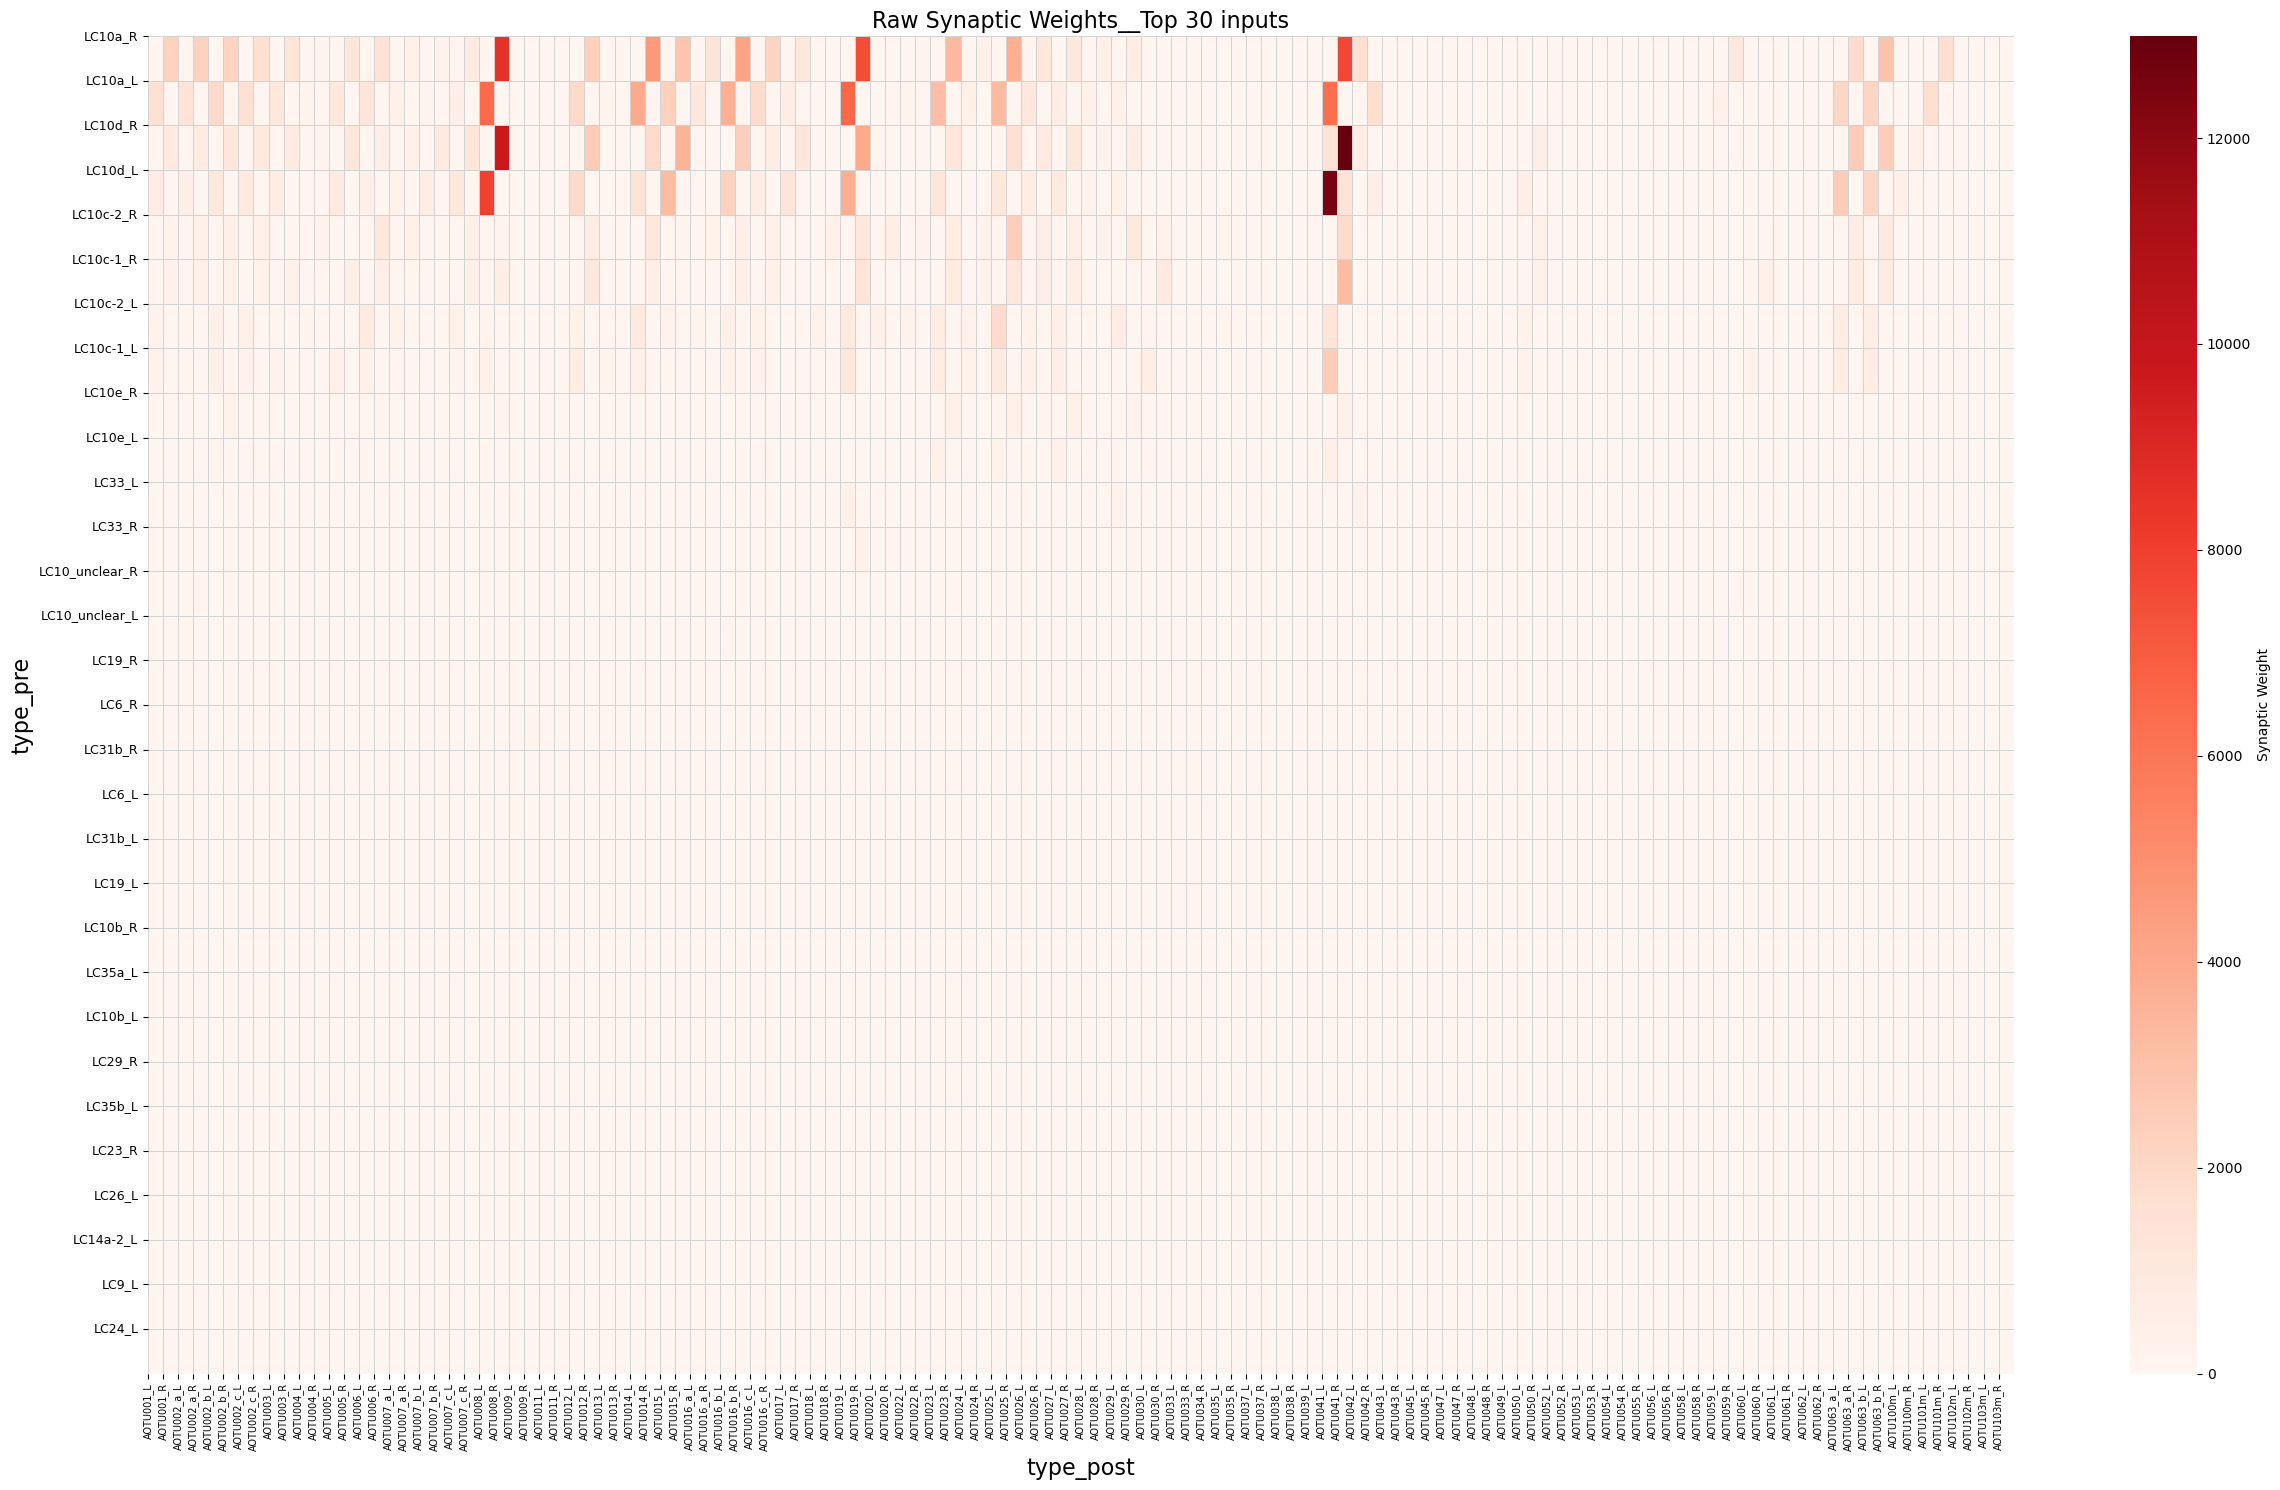

In [50]:
# top n inputs raw
n = 30

# Find top n AOTU types by total outgoing weight to DNs
top_inputs_raw = matrix_df.sum(axis=1).nlargest(n).index

# Slice submatrix for these AOTU pre types
top_input_matrix = matrix_df.loc[top_inputs_raw]

# Plot
plt.figure(figsize=(25, 15))
ax = sb.heatmap(top_input_matrix, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray',
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Raw Synaptic Weights__Top {n} inputs', fontsize = 16)
ax.set_xlabel('type_post', fontsize = 16)
ax.set_ylabel('type_pre', fontsize = 16)

ax.set_yticks(range(len(top_input_matrix.index)))
ax.set_yticklabels(top_input_matrix.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(top_input_matrix.columns)))
ax.set_xticklabels(top_input_matrix.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
plt.savefig('results/AOTU/Raw synaptic weights_LC_AOTU_top30inputs.png', dpi=600)

plt.show()

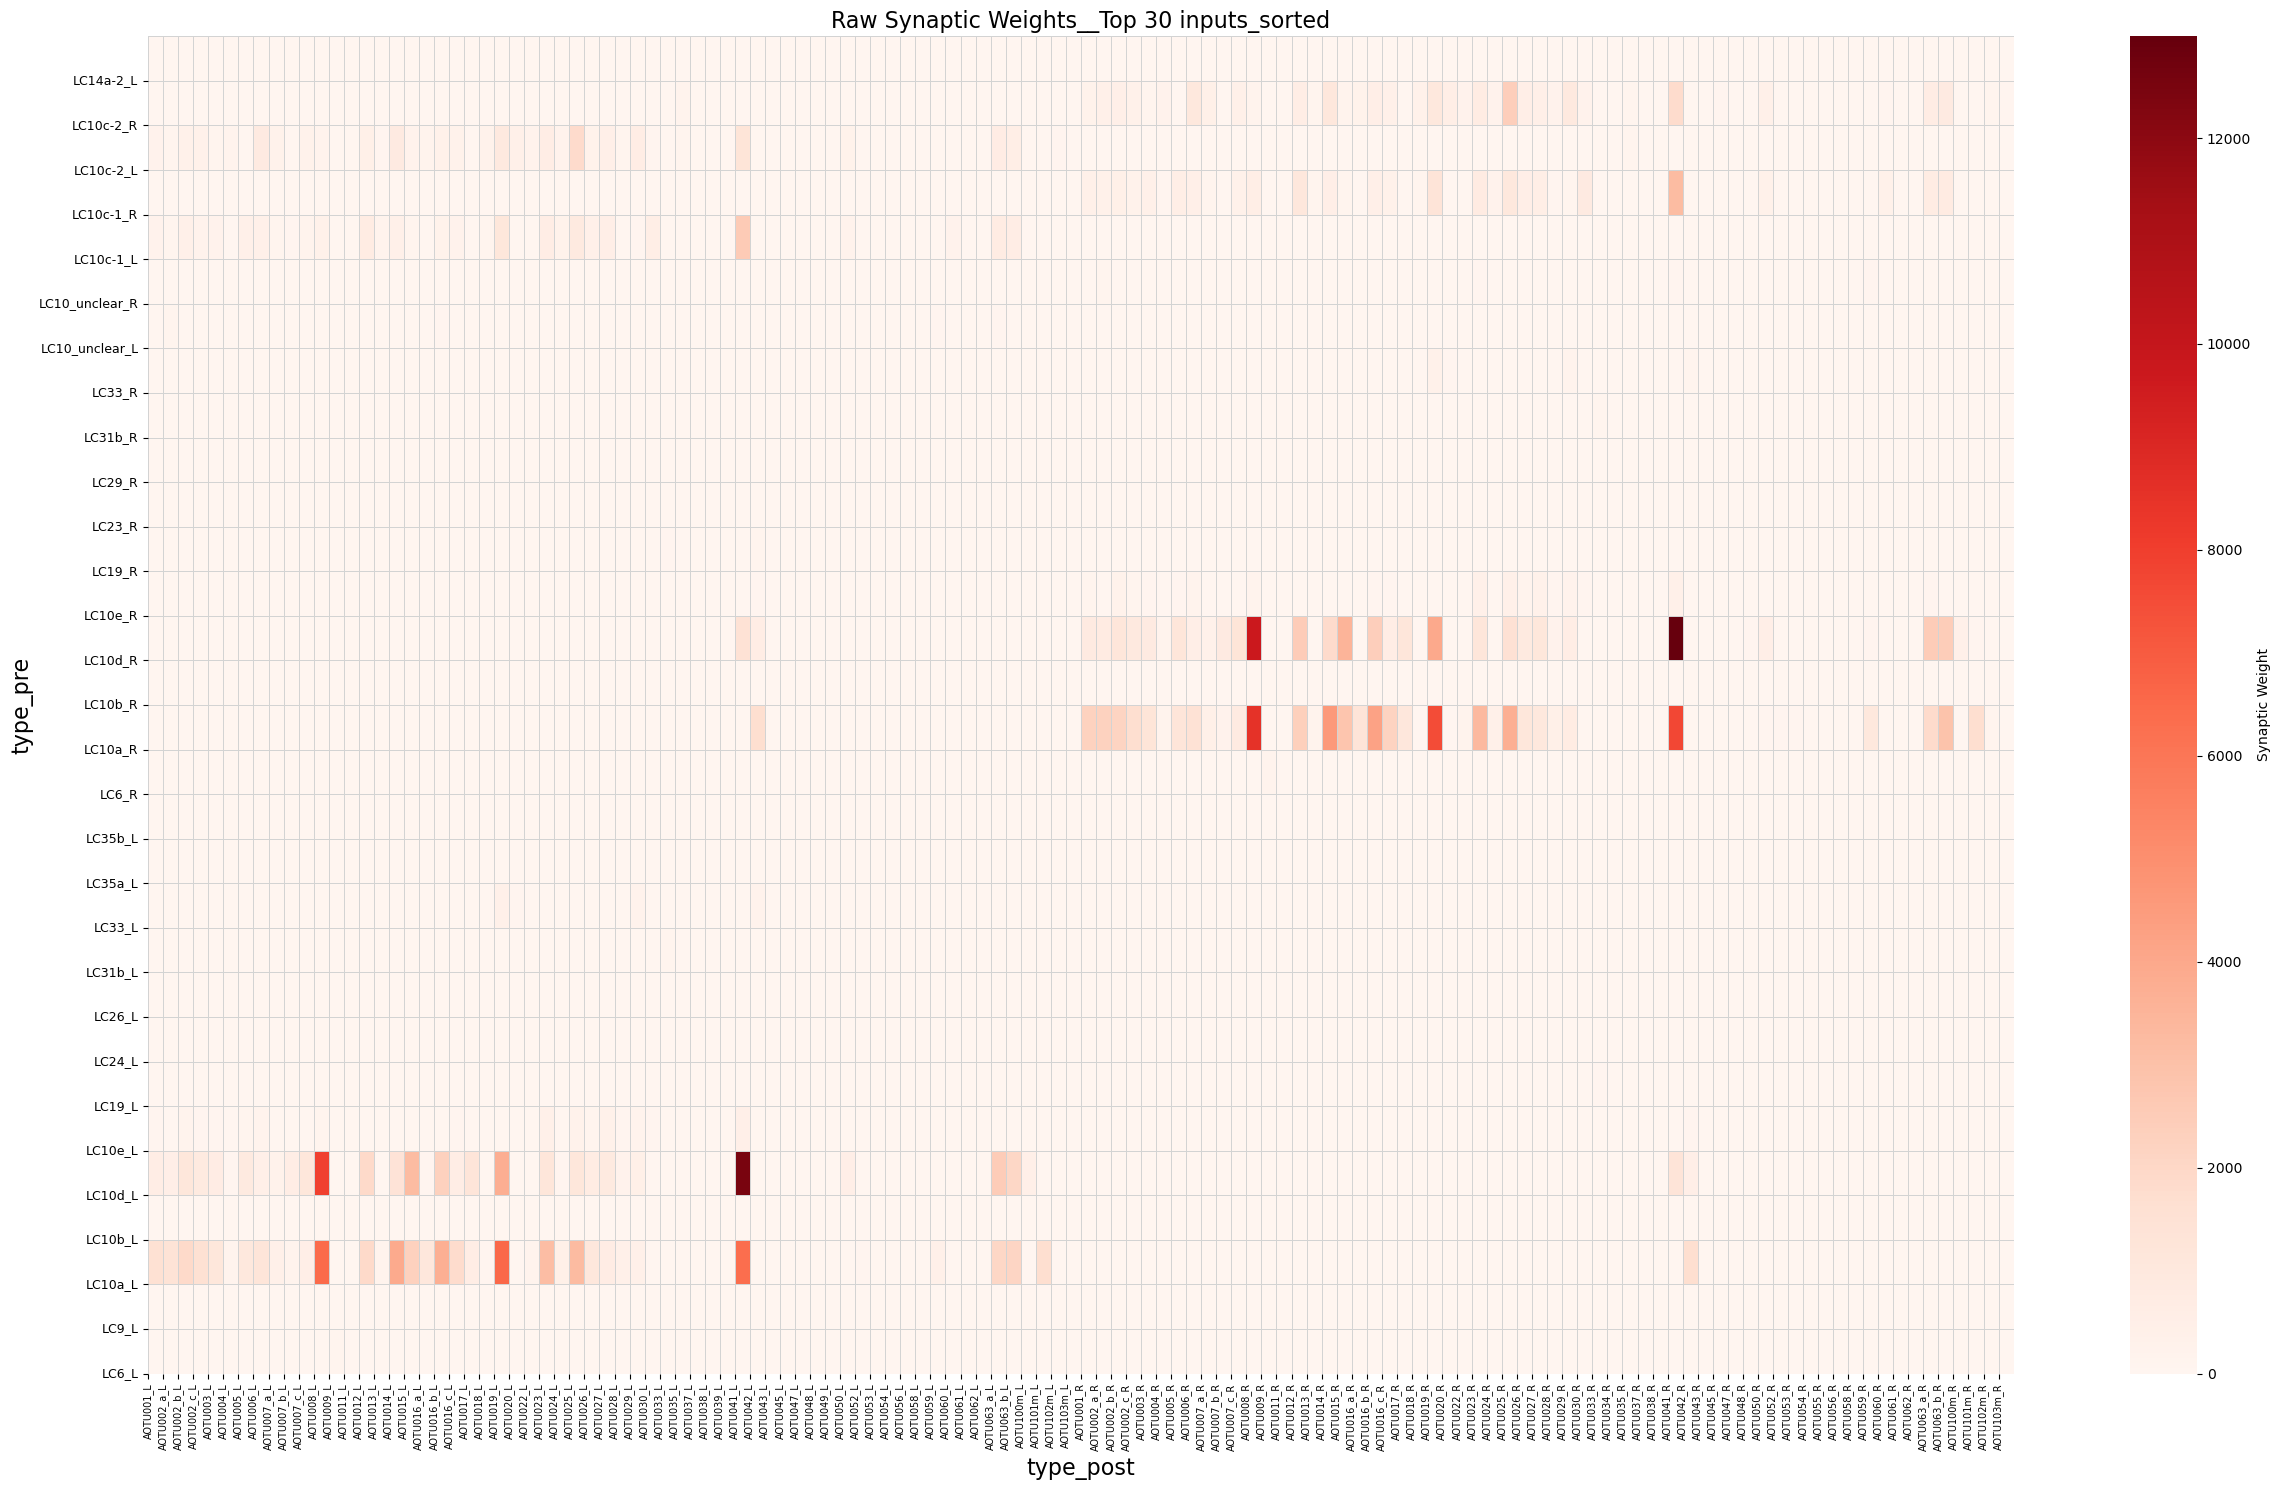

In [51]:
## Sorted heat map
n = 30

# Get top N AOTU instances by total output (rows)
top_inputs_raw = matrix_df.sum(axis=1).nlargest(n).index
top_input_matrix = matrix_df.loc[top_inputs_raw]

# Inline sort key (group by L/R, then ID, then subtype)
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and (m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)

# Apply sort to both rows and columns
sorted_rows = sorted(top_input_matrix.index, key=sort_key)
sorted_cols = sorted(top_input_matrix.columns, key=sort_key)

# Reorder matrix
ordered_top_input_matrix = top_input_matrix.loc[sorted_rows, sorted_cols]

# Plot
plt.figure(figsize=(25, 15))
ax = sb.heatmap(ordered_top_input_matrix, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray',
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Raw Synaptic Weights__Top {n} inputs_sorted', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_top_input_matrix.index)))
ax.set_yticklabels(ordered_top_input_matrix.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(ordered_top_input_matrix.columns)))
ax.set_xticklabels(ordered_top_input_matrix.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

# Save figure
plt.savefig(f'results/AOTU/Raw synaptic weights_LC_AOTU_top30inputs_sorted', dpi=600)
plt.show()


### Top n outputs raw

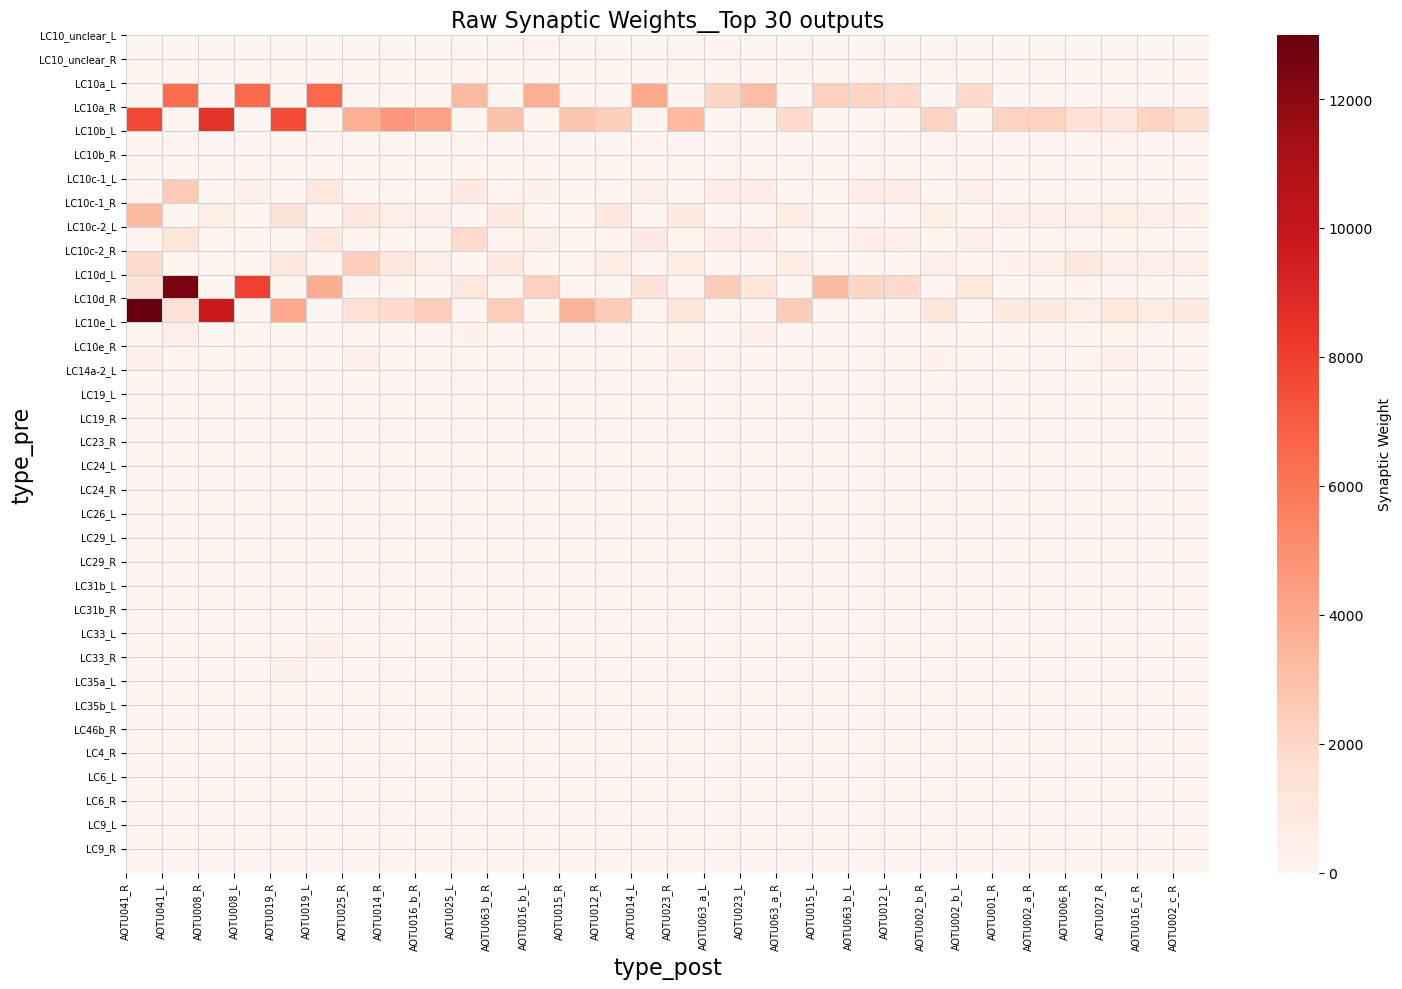

In [52]:
n = 30
# Top 30 posts (columns) by total input received
top_output_instances = matrix_df.sum(axis=0).nlargest(n).index
# Slice matrix: all pre, top 30 post
top_post_matrix = matrix_df.loc[:, top_output_instances]

# Plot
plt.figure(figsize=(15, 10))
ax = sb.heatmap(top_post_matrix, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Raw Synaptic Weights__Top {n} outputs', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(top_post_matrix.index)))
ax.set_yticklabels(top_post_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(top_post_matrix.columns)))
ax.set_xticklabels(top_post_matrix.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save figure
plt.savefig(f'results/AOTU/Raw synaptic weights_LC_AOTU_top30outputs.png', dpi=600)
plt.show()


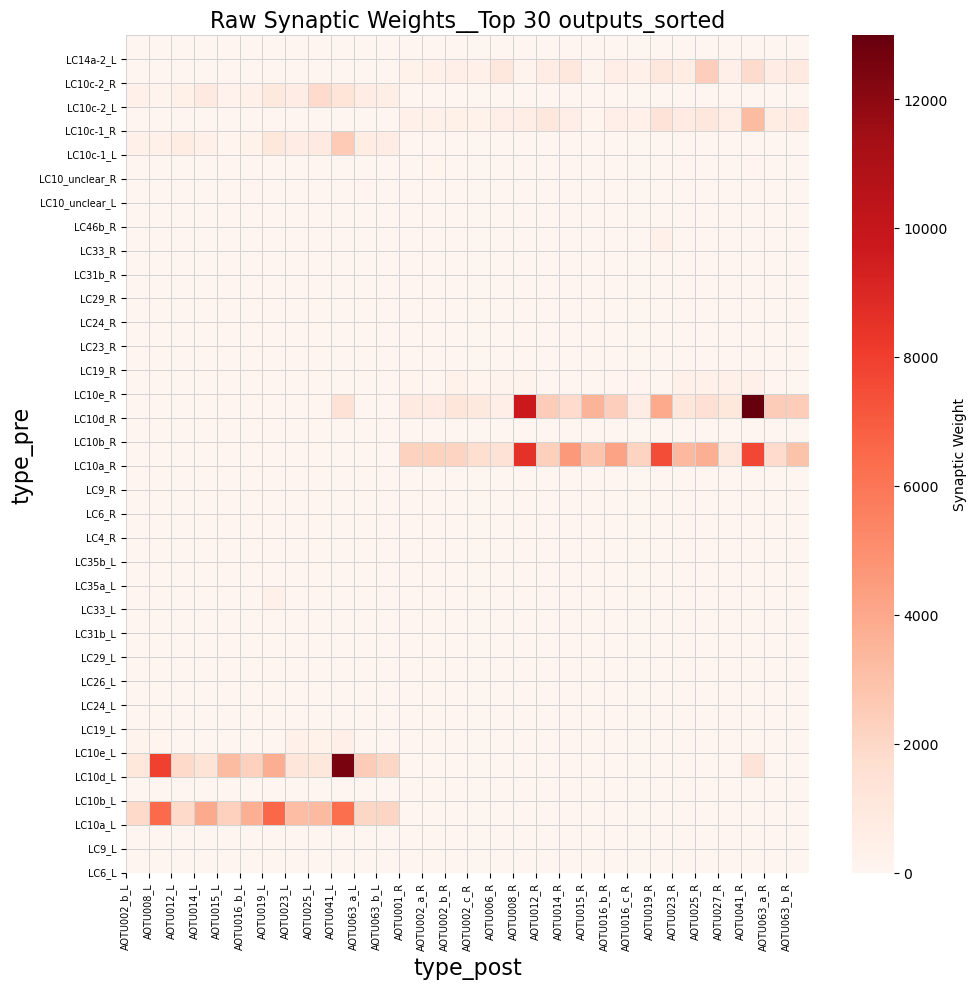

In [16]:
## Sorted heat map 

n = 30
# Step 1: Select top N post instances by total received weight
top_output_instances = matrix_df.sum(axis=0).nlargest(n).index
# Step 2: Slice matrix to all pre rows, top N post columns
top_post_matrix = matrix_df.loc[:, top_output_instances]

# Step 3: Define inline sort key (L/R → ID → subtype)
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and (m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)

# Step 4: Apply sorting
sorted_rows = sorted(top_post_matrix.index, key=sort_key)
sorted_cols = sorted(top_post_matrix.columns, key=sort_key)

# Step 5: Reorder matrix
ordered_top_post_matrix = top_post_matrix.loc[sorted_rows, sorted_cols]

# Step 6: Plot
plt.figure(figsize=(10, 10))
ax = sb.heatmap(ordered_top_post_matrix, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Raw Synaptic Weights__Top {n} outputs_sorted', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_top_post_matrix.index)))
ax.set_yticklabels(ordered_top_post_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(ordered_top_post_matrix.columns)))
ax.set_xticklabels(ordered_top_post_matrix.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

# Save file
plt.savefig(f'results/AOTU/Raw synaptic weights_LC_AOTU_top30outputs_sorted.png', dpi=600)

plt.show()


## Normalized all

In [11]:
# Create matrix of normalized weights
norm_matrix_df = conn_inst.pivot_table(index='instance_pre', columns='instance_post', values='wt_norm', aggfunc='sum', fill_value=0)

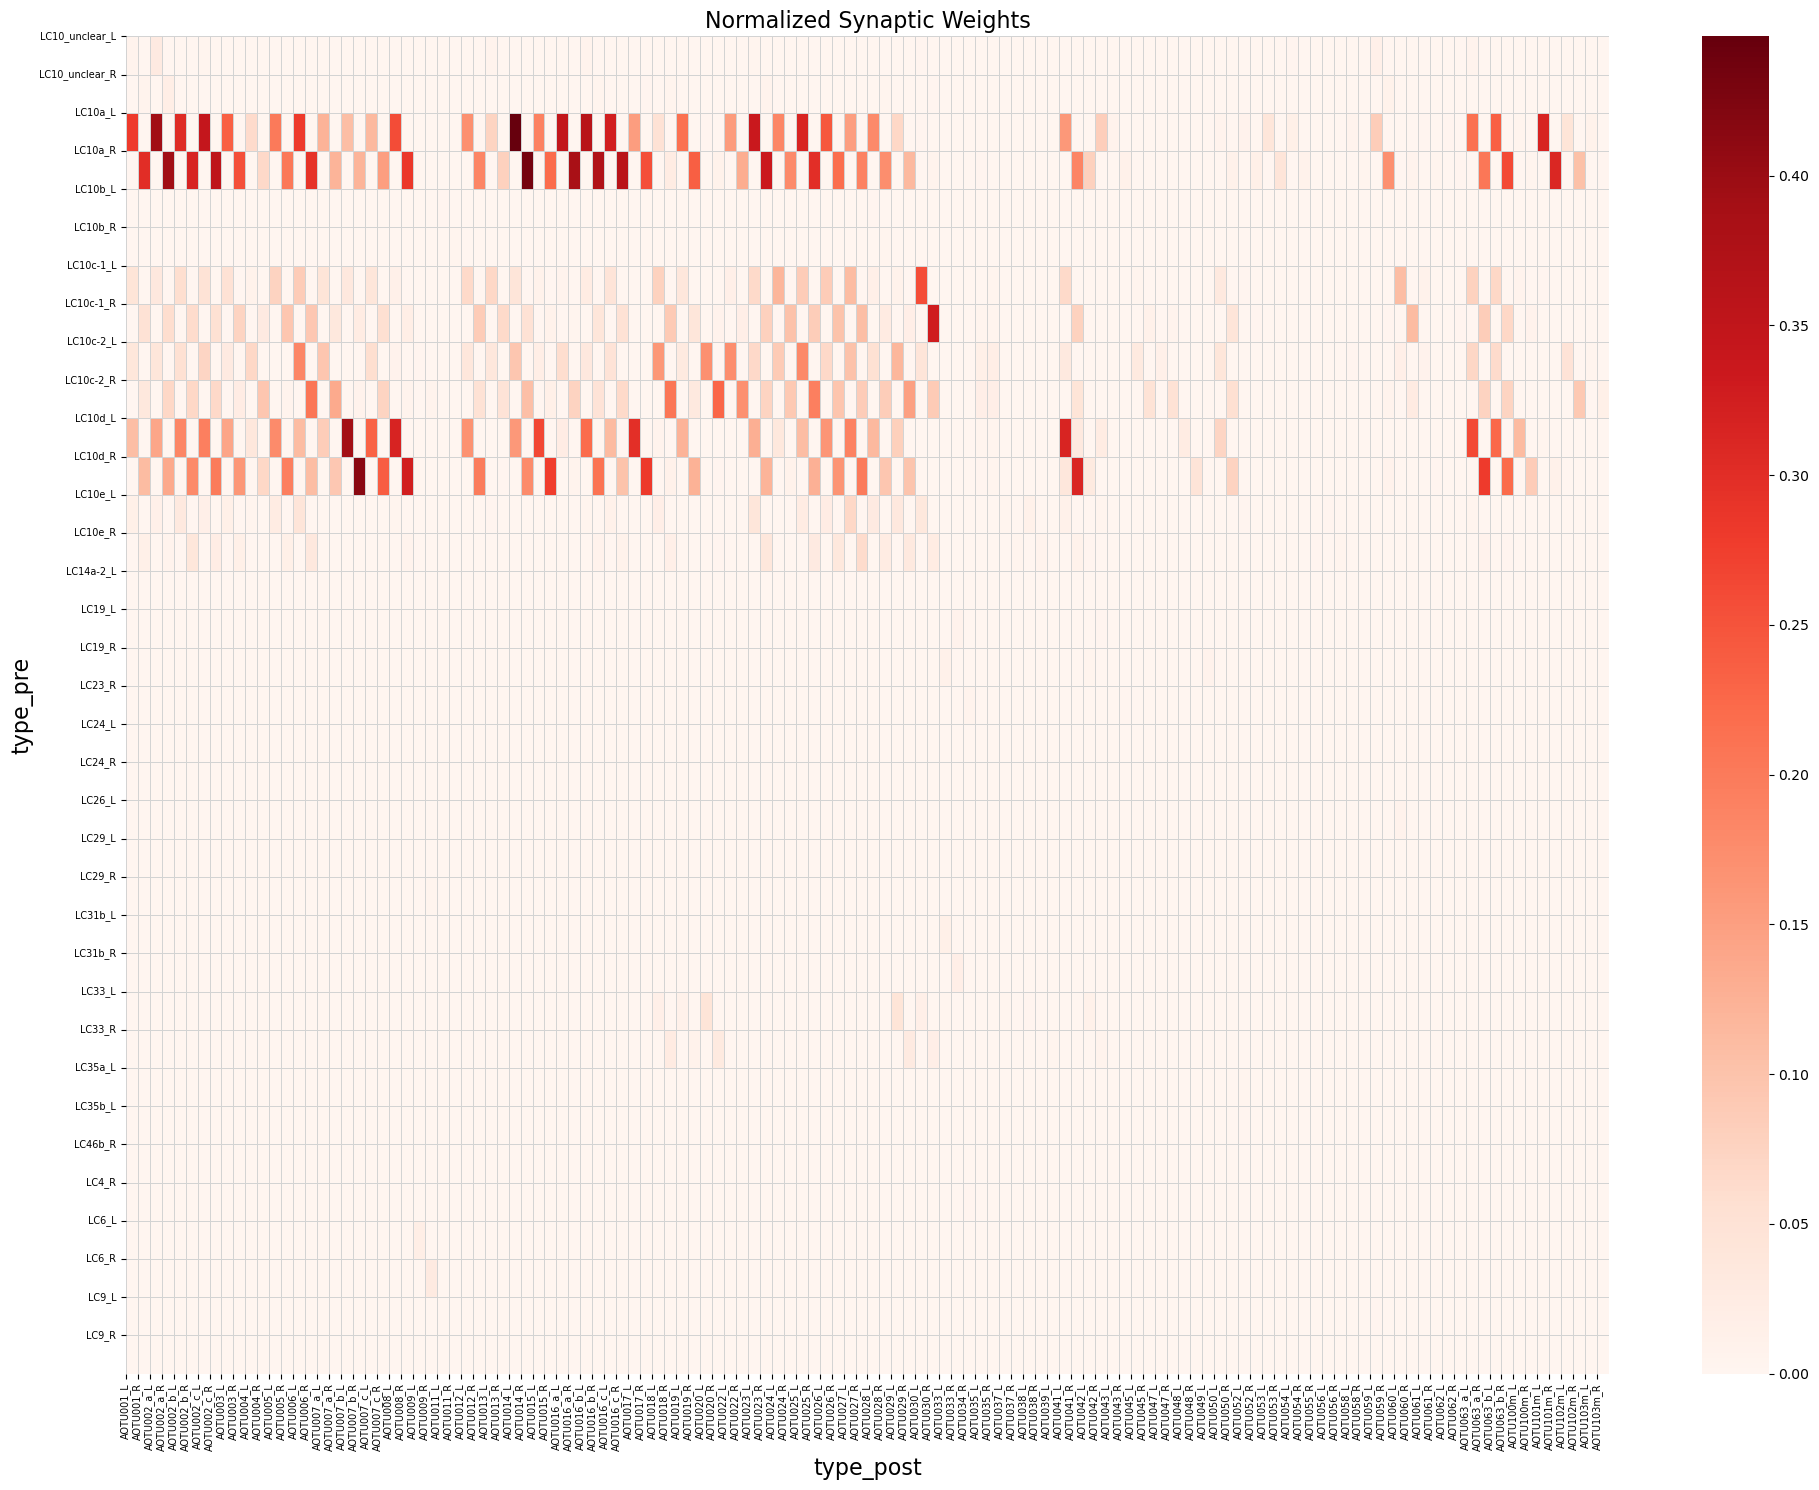

In [12]:
plt.figure(figsize=(20, 15))
ax = sb.heatmap(norm_matrix_df, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray')

ax.set_title('Normalized Synaptic Weights', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(norm_matrix_df.index)))
ax.set_yticklabels(norm_matrix_df.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(norm_matrix_df.columns)))
ax.set_xticklabels(norm_matrix_df.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/AOTU/Normalized synaptic weights_LC_AOTU_all.png', dpi=600)

plt.show()

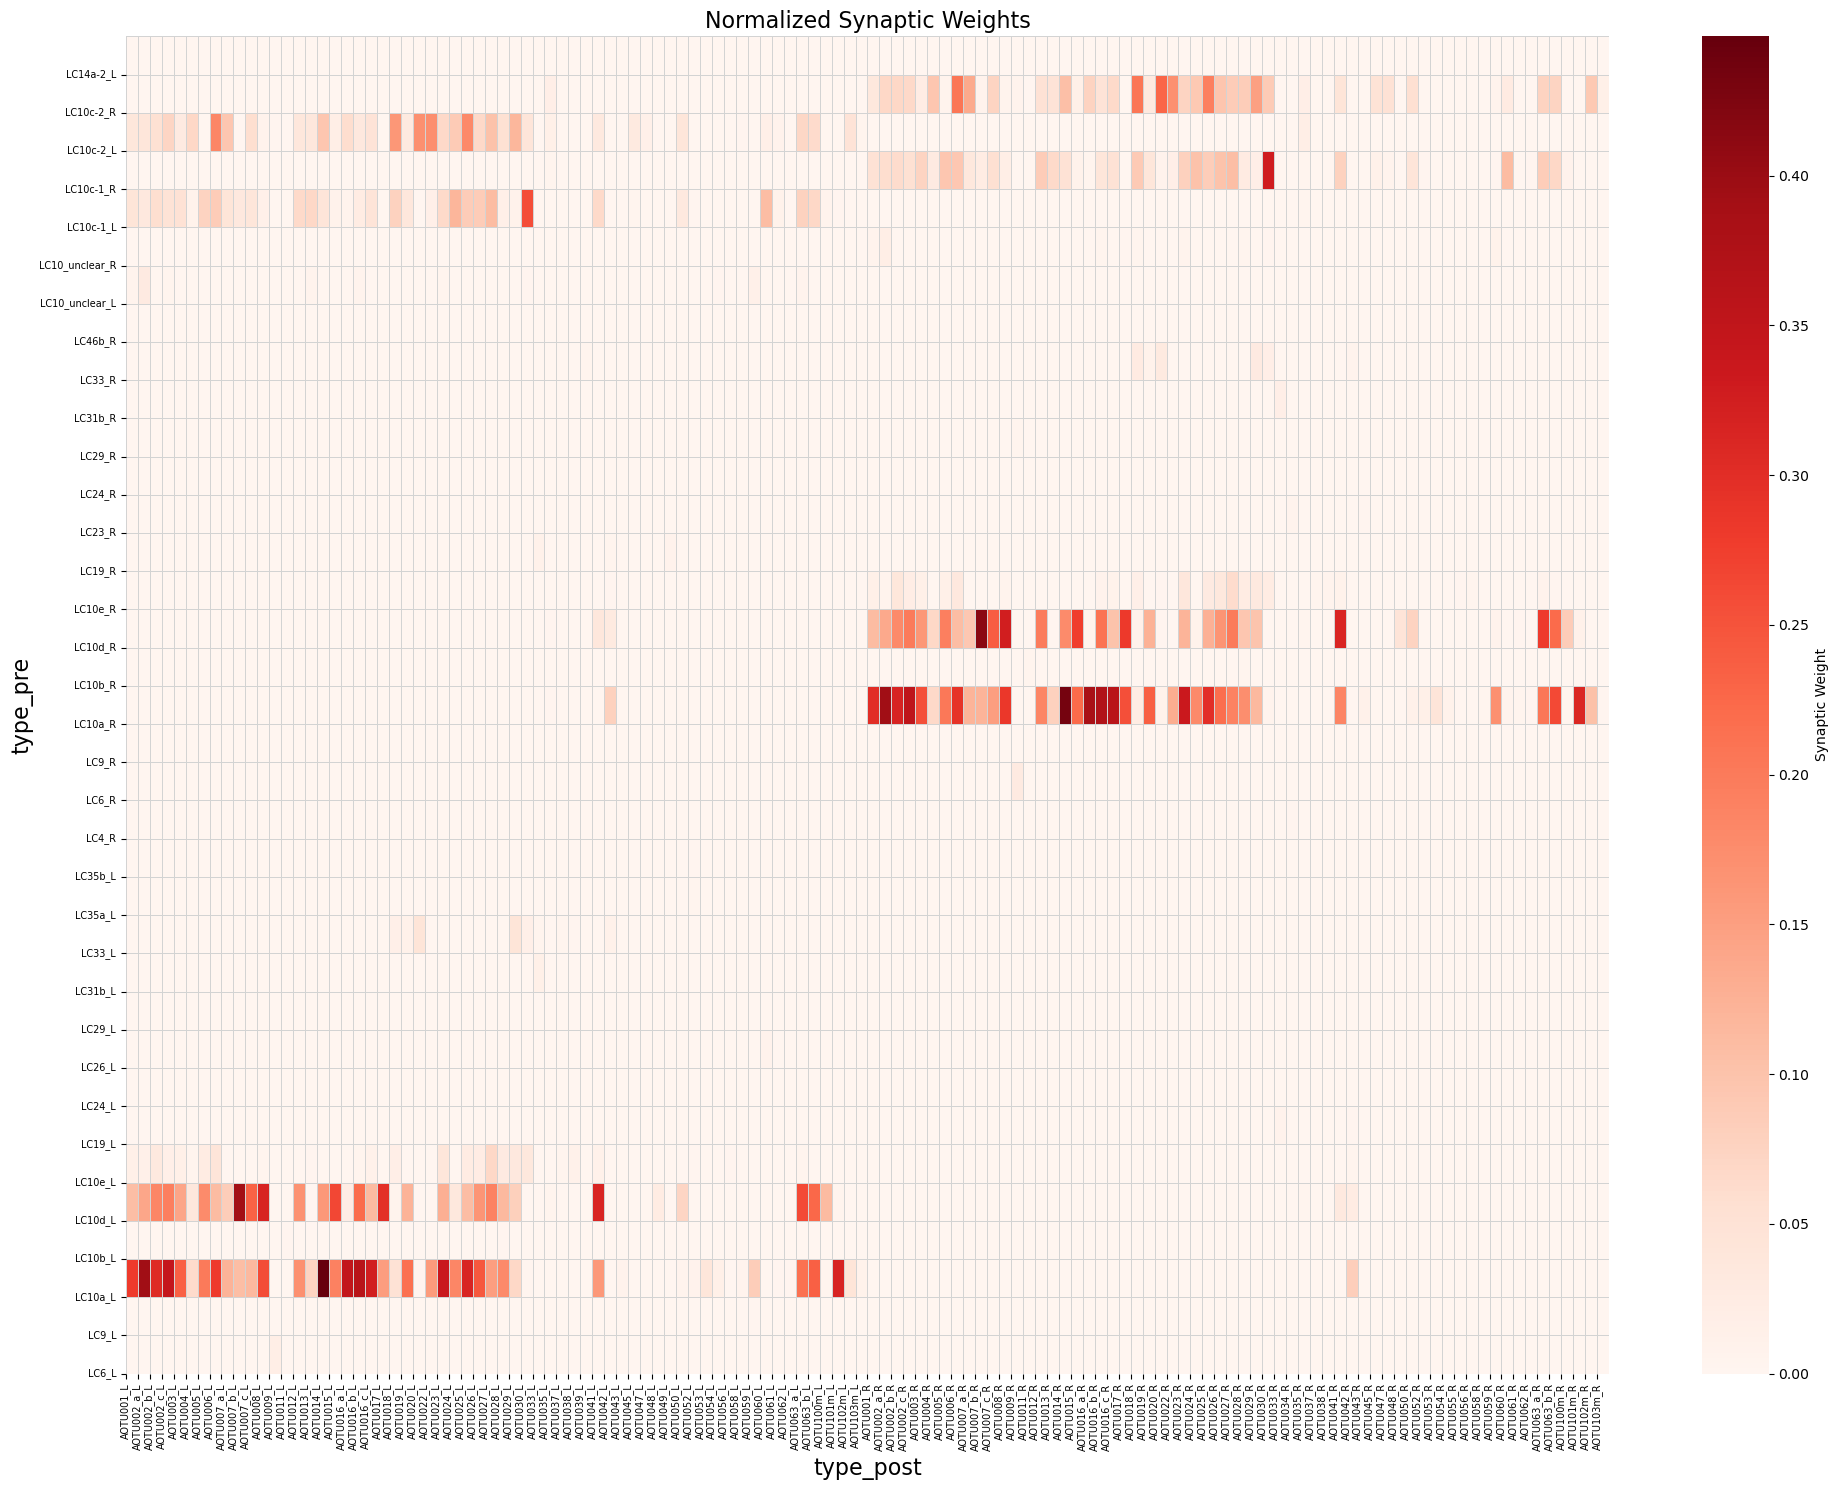

In [13]:

# Inline sorting using lambda
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and(m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)  # fallback if no match

# Get sorted row and column order
sorted_rows = sorted(norm_matrix_df.index, key=sort_key)
sorted_cols = sorted(norm_matrix_df.columns, key=sort_key)

# Reorder the matrix
ordered_matrix = norm_matrix_df.loc[sorted_rows, sorted_cols]

plt.figure(figsize=(20, 15))
ax = sb.heatmap(ordered_matrix, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray', cbar_kws={"label": "Synaptic Weight"})

ax.set_title('Normalized Synaptic Weights', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_matrix.index)))
ax.set_yticklabels(ordered_matrix.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(ordered_matrix.columns)))
ax.set_xticklabels(ordered_matrix.columns, rotation=90, fontsize=7)

ax.invert_yaxis()

plt.tight_layout()
plt.savefig('results/AOTU/Normalized synaptic weights_LC_AOTU_all_sorted.png', dpi=600)
plt.show()

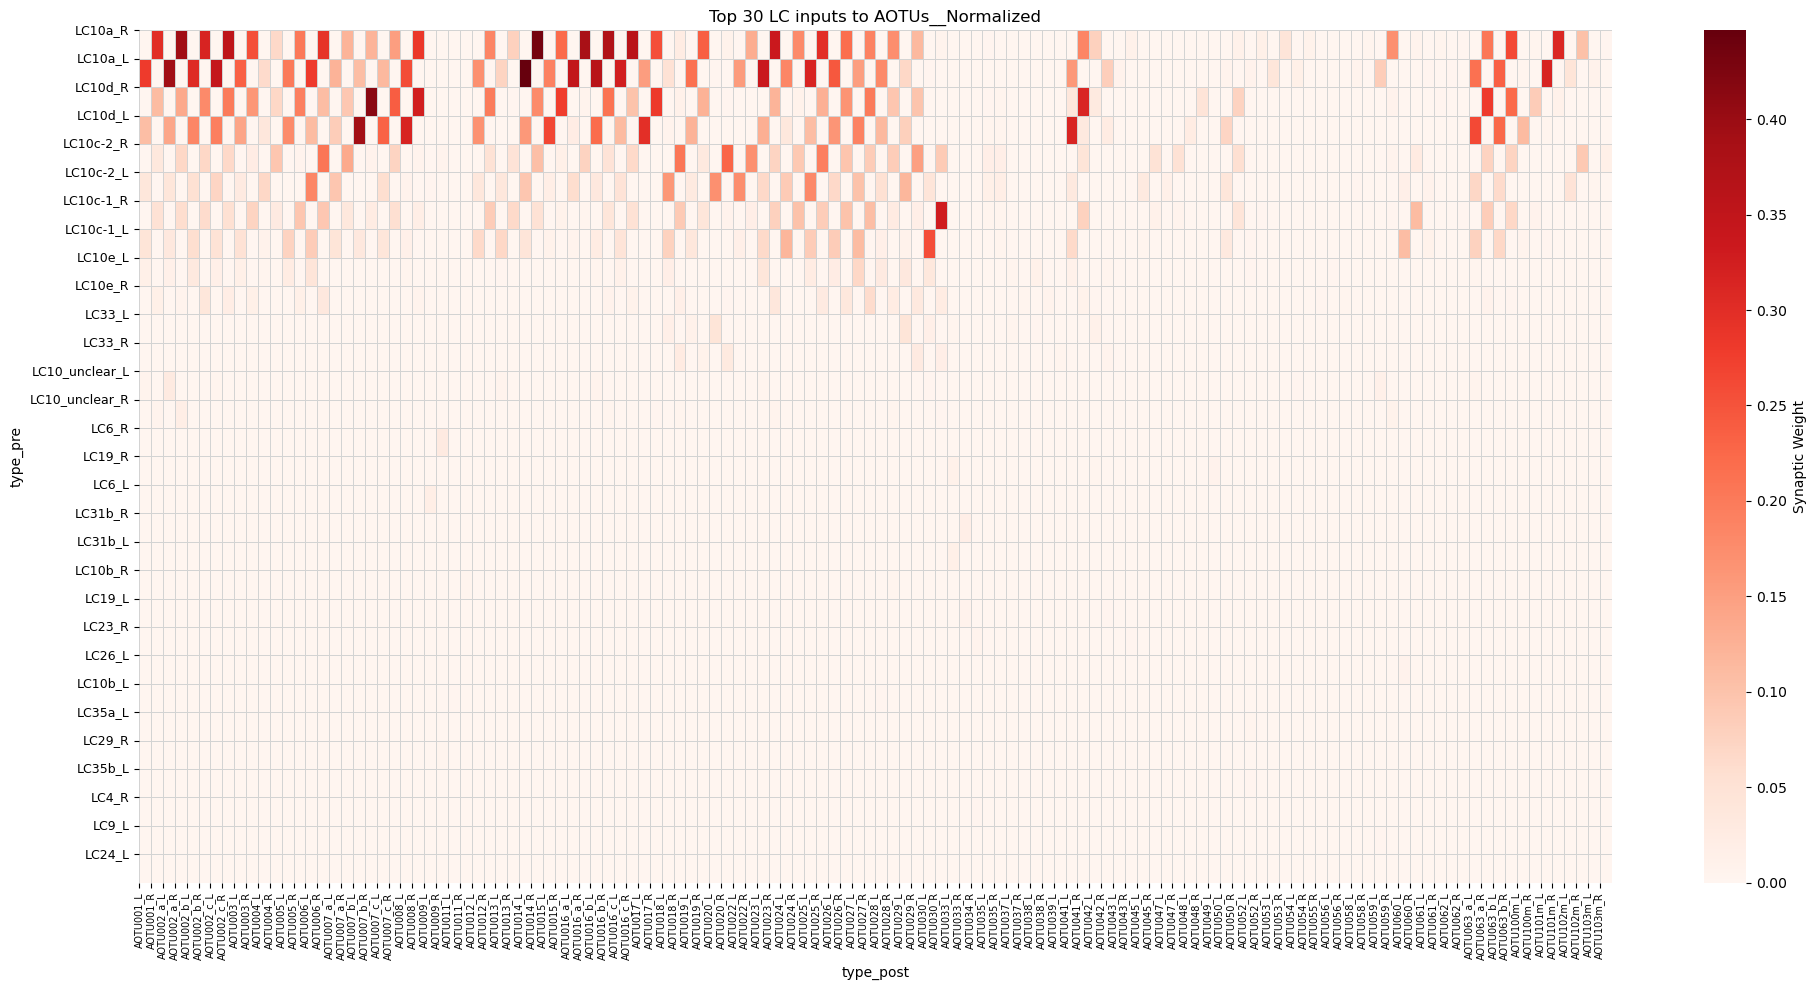

In [56]:
n = 30
# Find top n AOTU types by total outgoing weight to DNs
top_inputs_norm = norm_matrix_df.sum(axis=1).nlargest(n).index

# Slice submatrix for these AOTU pre types
top_input_matrix_norm = norm_matrix_df.loc[top_inputs_norm]

# Plot
plt.figure(figsize=(20, 10))
ax = sb.heatmap(top_input_matrix_norm, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray',
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'Top {n} LC inputs to AOTUs__Normalized')
ax.set_xlabel('type_post')
ax.set_ylabel('type_pre')

ax.set_yticks(range(len(top_input_matrix_norm.index)))
ax.set_yticklabels(top_input_matrix_norm.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(top_input_matrix_norm.columns)))
ax.set_xticklabels(top_input_matrix_norm.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save plot to file
os.makedirs('results', exist_ok=True)
plt.savefig('results/AOTU/Normalized synaptic weights_LC_AOTU_Top30_inputs.png', dpi=600)

plt.show()

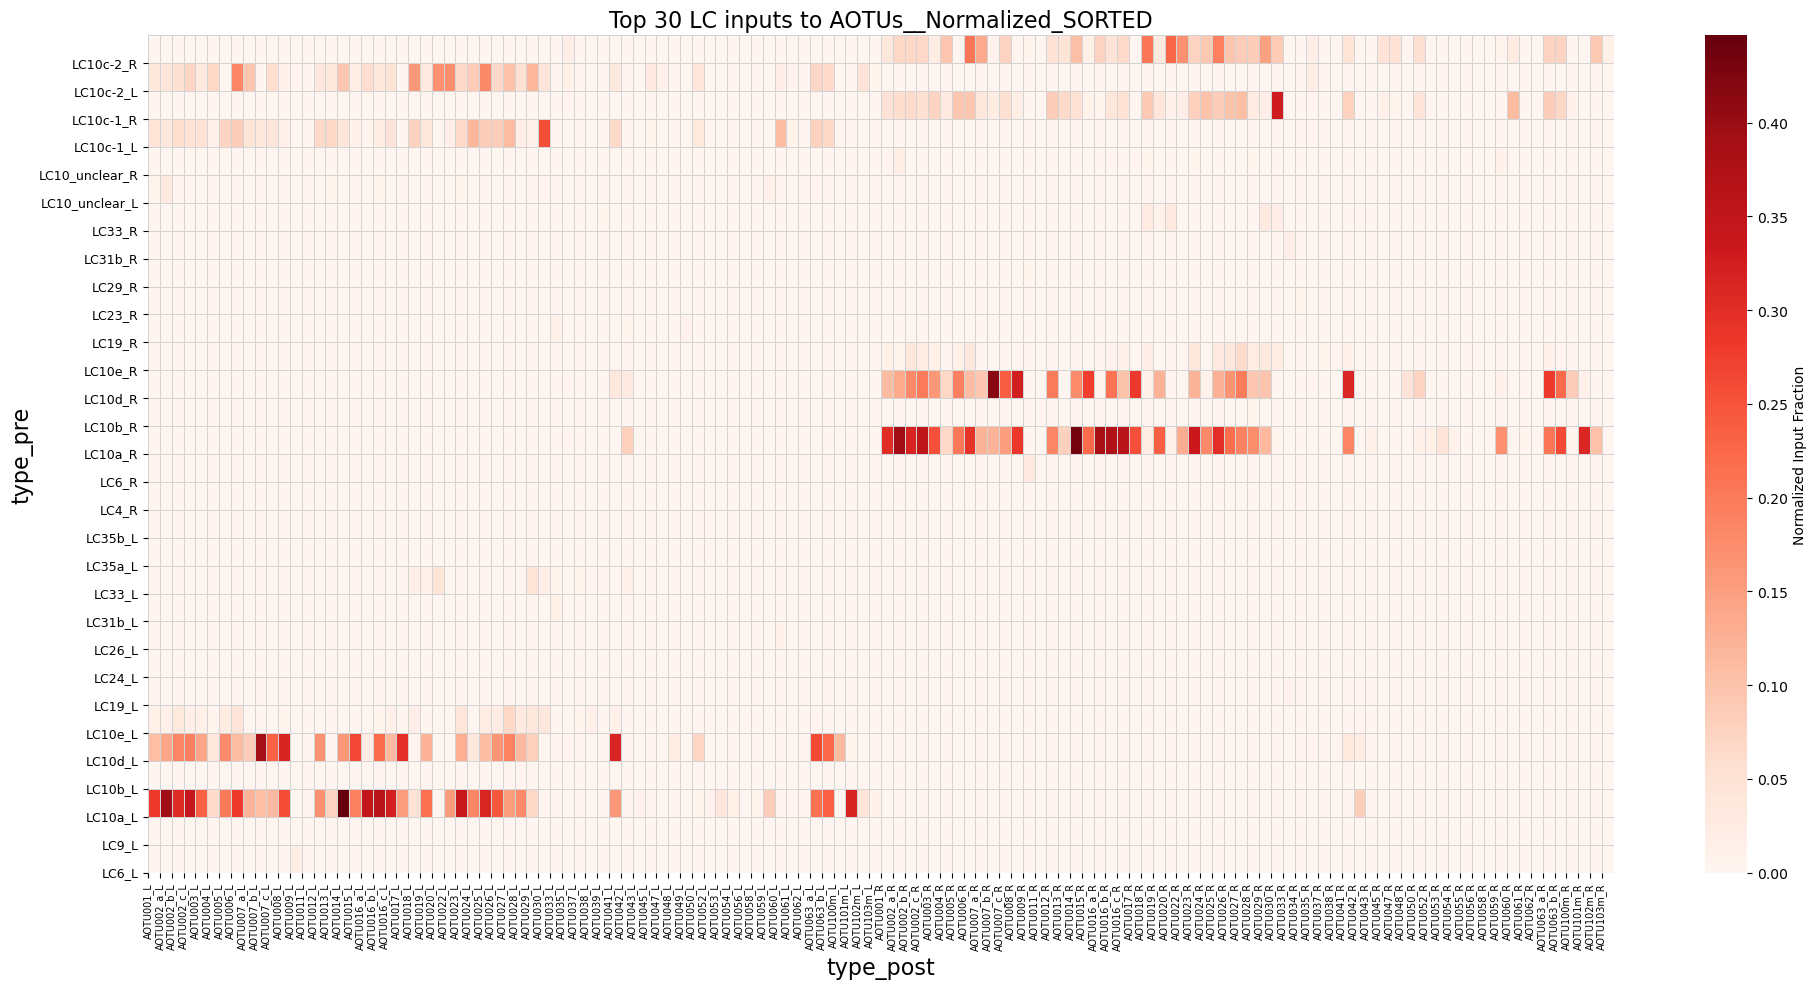

In [57]:
n = 30

# Step 1: Find top N AOTU types by total normalized output
top_inputs_norm = norm_matrix_df.sum(axis=1).nlargest(n).index
# Step 2: Slice normalized matrix by top N pre instances
top_input_matrix_norm = norm_matrix_df.loc[top_inputs_norm]

# Step 3: Define sorting key (inline)
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and (m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)

# Step 4: Sort rows and columns
sorted_rows = sorted(top_input_matrix_norm.index, key=sort_key)
sorted_cols = sorted(top_input_matrix_norm.columns, key=sort_key)

# Step 5: Reorder the matrix
ordered_top_input_matrix_norm = top_input_matrix_norm.loc[sorted_rows, sorted_cols]

# Step 6: Plot
plt.figure(figsize=(20, 10))
ax = sb.heatmap(ordered_top_input_matrix_norm, cmap='Reds', annot=False, linewidths=0.5,
                linecolor='lightgray', cbar_kws={"label": "Normalized Input Fraction"})

ax.set_title(f'Top {n} LC inputs to AOTUs__Normalized_SORTED', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_top_input_matrix_norm.index)))
ax.set_yticklabels(ordered_top_input_matrix_norm.index, rotation=0, fontsize=9)
ax.set_xticks(range(len(ordered_top_input_matrix_norm.columns)))
ax.set_xticklabels(ordered_top_input_matrix_norm.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

# Save
plt.savefig('results/AOTU/Normalized synaptic weights_LC_AOTU_Top30_inputs_sorted.png', dpi=600)

plt.show()


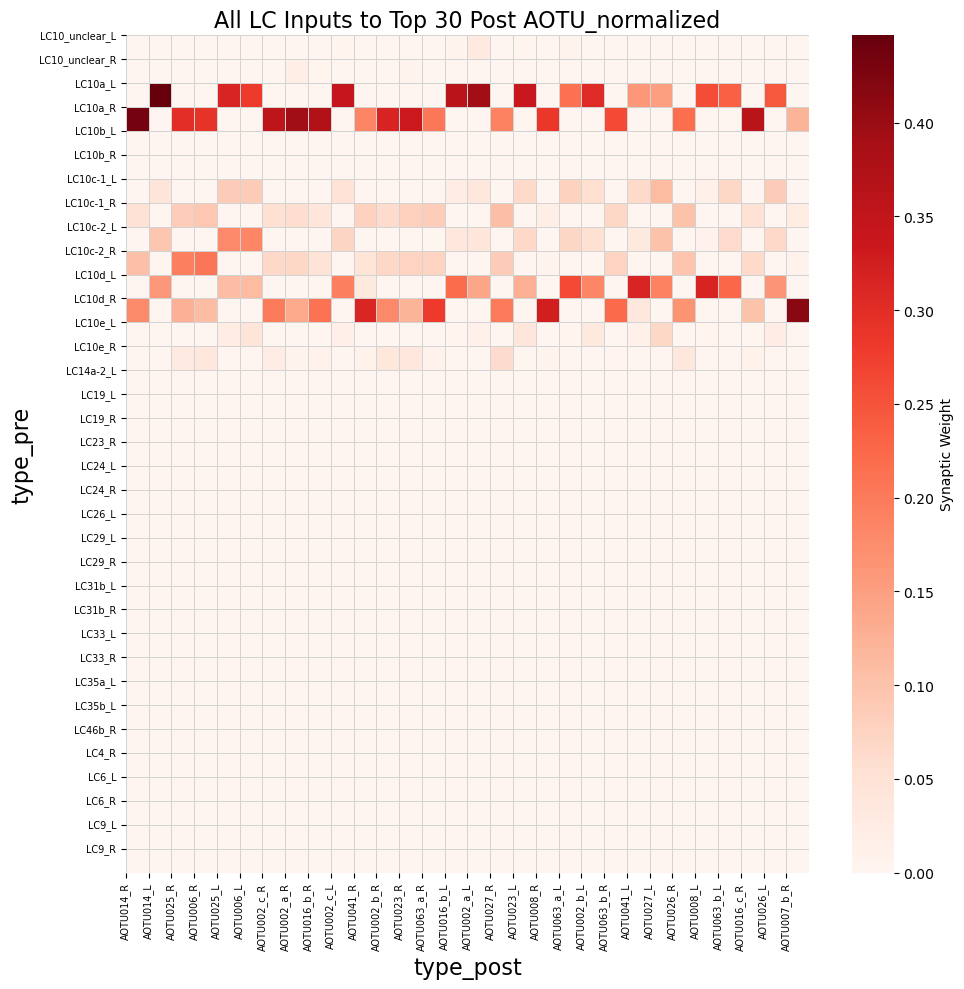

In [14]:
n = 30
# Top 30 posts (columns) by total input received
top_output_instances_norm = norm_matrix_df.sum(axis=0).nlargest(n).index
# Slice matrix: all pre, top 30 post
top_post_matrix_norm = norm_matrix_df.loc[:, top_output_instances_norm]

# Plot
plt.figure(figsize=(10, 10))
ax = sb.heatmap(top_post_matrix_norm, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Synaptic Weight"})

ax.set_title(f'All LC Inputs to Top {n} Post AOTU_normalized', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(top_post_matrix_norm.index)))
ax.set_yticklabels(top_post_matrix_norm.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(top_post_matrix_norm.columns)))
ax.set_xticklabels(top_post_matrix_norm.columns, rotation=90, fontsize=7)

plt.tight_layout()

# Save figure
plt.savefig('results/AOTU/Normalized synaptic weights_LC_AOTU_Top30_outputs.png', dpi=600)

plt.show()

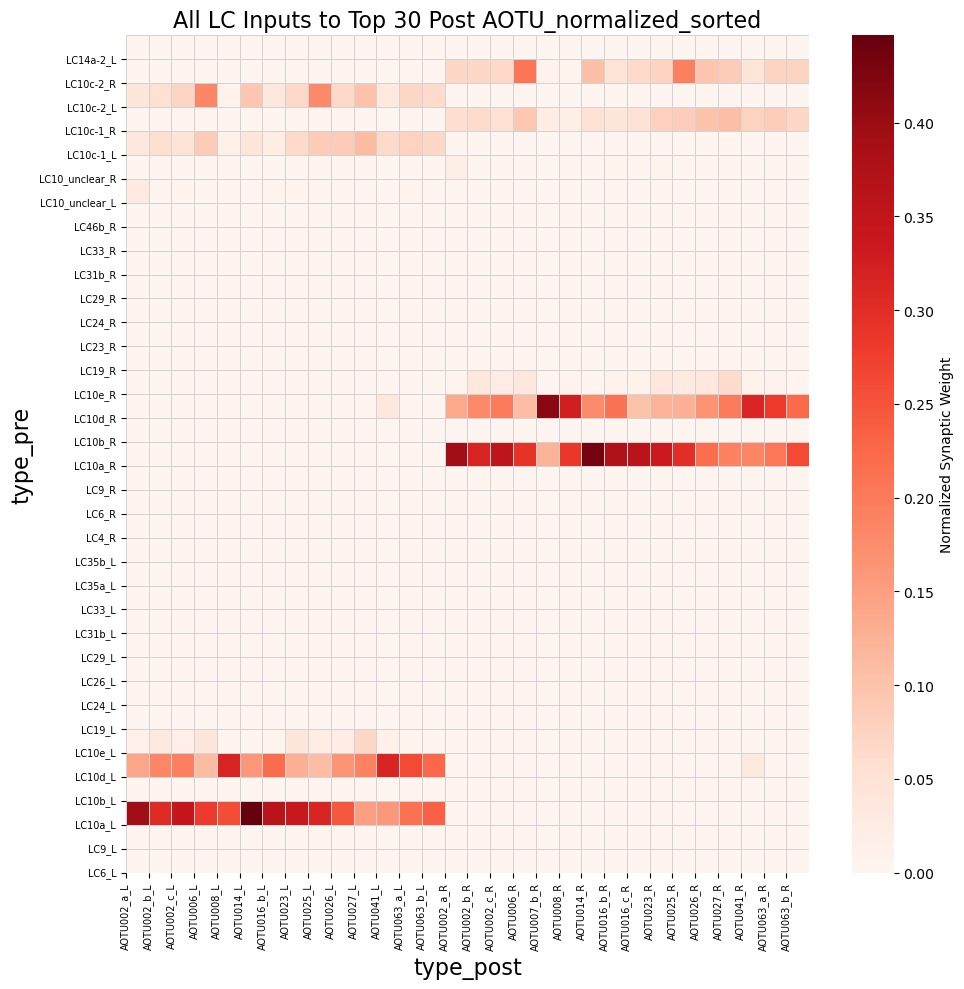

In [15]:
n = 30

# Step 1: Get top N post instances by total normalized input
top_output_instances_norm = norm_matrix_df.sum(axis=0).nlargest(n).index

# Step 2: Slice normalized matrix to include all rows, top N columns
top_post_matrix_norm = norm_matrix_df.loc[:, top_output_instances_norm]

# Step 3: Sorting key (L/R → ID → subtype)
sort_key = lambda x: ((m := re.match(r'([A-Z]+)(\d+)_?([a-zA-Z]?)_([LR])$', x)) and (m.group(4), int(m.group(2)), m.group(3), x)) or ('Z', 9999, '', x)

# Step 4: Sort both rows and columns
sorted_rows = sorted(top_post_matrix_norm.index, key=sort_key)
sorted_cols = sorted(top_post_matrix_norm.columns, key=sort_key)

# Step 5: Reorder matrix
ordered_top_post_matrix_norm = top_post_matrix_norm.loc[sorted_rows, sorted_cols]

# Step 6: Plot
plt.figure(figsize=(10, 10))
ax = sb.heatmap(ordered_top_post_matrix_norm, cmap='Reds', annot=False, linewidths=0.5, linecolor='lightgray',  
                cbar_kws={"label": "Normalized Synaptic Weight"})

ax.set_title(f'All LC Inputs to Top {n} Post AOTU_normalized_sorted', fontsize=16)
ax.set_xlabel('type_post', fontsize=16)
ax.set_ylabel('type_pre', fontsize=16)

ax.set_yticks(range(len(ordered_top_post_matrix_norm.index)))
ax.set_yticklabels(ordered_top_post_matrix_norm.index, rotation=0, fontsize=7)
ax.set_xticks(range(len(ordered_top_post_matrix_norm.columns)))
ax.set_xticklabels(ordered_top_post_matrix_norm.columns, rotation=90, fontsize=7)

ax.invert_yaxis()
plt.tight_layout()

# Save
os.makedirs('results', exist_ok=True)
plt.savefig('results/AOTU/Normalized synaptic weights_LC_AOTU_Top30_outputs_sorted.png', dpi=600)

plt.show()
